In [7]:
import networkx as nx
from enum import Enum
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import operator

In [8]:
import util

In [9]:
import strategy_vector_manipulator as strategy

In [10]:
import init_sentiment

In [11]:
import stubborn_nodes

In [12]:
# !pip install networkit
# !pip install oct2py
# import get_BTER_graph

In [13]:
def threshold_process(S0, theta, graph, verbose):
    'S0 is a set, theta is the threshold vector'

    V = set(graph)
    t = 0
    S = S0
    
    #calculate each node's d(i, S0) first
    dS = {}
    
    for i in V:
        dsi = 0
        for j in graph.neighbors(i):
            if j in S:
                dsi += 1
        dS.update({i:dsi})
    
#     print("initial dS: ", dS)
    
    new_added = True
    
    while(new_added):
        t += 1
        new_added = False
        
        for i in V.difference(S):
            if dS[i] >= theta[i]:
                S.add(i) ## add the node to set S
                new_added = True
                
                ## now increment the dS of i's neighbors
                for j in graph.neighbors(i):
                    dS[j] += 1
            
        if(verbose):
            print("t = ", t, ", S = ", S, '\n')
    
    if(verbose):
        print("T = ", t)
        print("S_T = ", S)
    
    return S

In [15]:
def get_theta(graph, alpha, C):
    'θv = d(v)/2 − Cv/ 2α'
    
    theta = {}
    
    for i in graph.nodes:
        theta_i = graph.degree(i) /2 - C[i]/(2*alpha)
        theta.update({i:theta_i})
    
    return theta

In [17]:
def get_S0(alpha, C, graph):
    S0 = set()
    for i in graph.nodes:
        if(graph.degree(i) < C[i]/alpha):
            S0.add(i)
    return S0

#sanity check
# C = [-1 for i in range(len(g))]
# S0 = get_S0(alpha = 1, C = C, graph = g)

# theta = get_theta(graph= g, alpha = 1, C = C)

# S_T = threshold_process(S0= S0, theta = theta, graph = g, verbose=True)

# len(S_T)

In [209]:
'''Load Graph'''
############# params of graph ############################
N = 1000
M = 20
PROB_TRIANGLE = 0.3
prob_edge = 0.2
#########################################################
# g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
# g = nx.read_edgelist("../data/facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/email-EU-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
g = nx.read_gexf("../data/twitter_sentiment_200.gexf", node_type=None, relabel=False, version='1.1draft')

n = len(g)
m = g.number_of_edges()
# triangles = sum(nx.triangles(g).values())//3
davg = sum(dict(g.degree).values())/len(g)
ccavg = nx.average_clustering(g)


print('|V| = ', n)
print('|E| = ', m)
# print('Triangles: ', triangles)
print('Avg degree: ', davg)
print('CC_avg: ', ccavg)

print(n, ' & ', m , ' & ', davg , ' & ', ccavg)

|V| =  9527
|E| =  82709
Avg degree:  17.36307337042091
CC_avg:  0.05051460526371834
9527  &  82709  &  17.36307337042091  &  0.05051460526371834


In [210]:
# nx.draw(g)

136.0


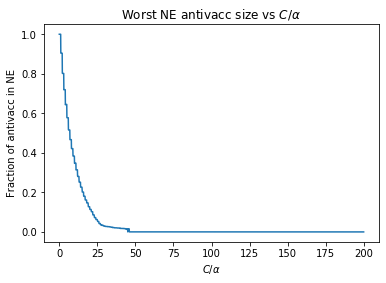

In [211]:
start = 0
end = 200
interval = 0.1
C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]

c = np.arange(start, end, interval)
worst_NE_size = []

alpha = 1

for C in C_list:
    S0 = get_S0(alpha = alpha, C = C, graph = g)

    theta = get_theta(graph= g, alpha = alpha, C = C)

    S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

#     print(S_T)
    
    worst_NE_size.append(len(g)-len(S_T))
    

for i in range(len(worst_NE_size)):
    if(worst_NE_size[i]  == 0 ):
        print(c[i])
        break
    
plt.plot(c, np.array(worst_NE_size)/len(g))
plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')
plt.savefig('fig.eps')

# set(g).difference(S_T)


In [212]:
wtwitter = worst_NE_size

In [213]:
wne = [werdos, wtwitter, wfb, wp2p, wemail]
legend = ['Erdos-Renyi', 'Twitter Mentions', 'Facebook', 'Gnutella p2p', 'email-EU-core']


In [214]:
# heh10 = set(g).difference(S_T)
# np.save('heh10', list(heh10))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


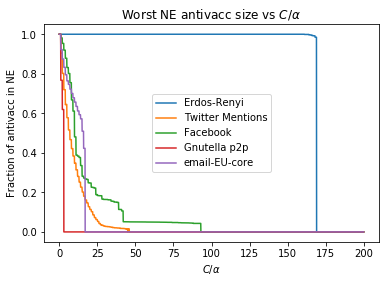

In [215]:
for w in wne:
    plt.plot(c, np.array(w)/w[0])
    
# plt.plot(c, np.array(wne[0])/wne[0][0], color='red')
    
    
plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')
plt.legend(legend)
plt.savefig('wne.eps')

5.0
28.0
52.0
78.0
105.0
131.0
159.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


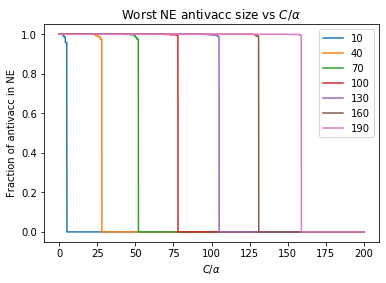

In [28]:
'7.2'

start = 0
end = 200
interval = 0.1

c = np.arange(start, end, interval)

alpha = 1

wd = {}

for p in range(0,1, 0.05):
    N = 1000
    g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
    
    C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]
    
    worst_NE_size = []

    for C in C_list:
        S0 = get_S0(alpha = alpha, C = C, graph = g)

        theta = get_theta(graph= g, alpha = alpha, C = C)

        S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

        worst_NE_size.append(len(g)-len(S_T))

    wd.update({d:worst_NE_size})

    for i in range(len(worst_NE_size)):
        if(worst_NE_size[i] == 0):
            print(c[i])
            break

            
            for d in wd:
    plt.plot(c, np.array(wd[d])/wd[d][0])


plt.xlim(0, 230)

plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')


legend = list(wd.keys())
legend = [r'$E[d] = $' + str(legend[i]) for i in range(len(legend))]

plt.legend(legend)
plt.savefig('wd.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


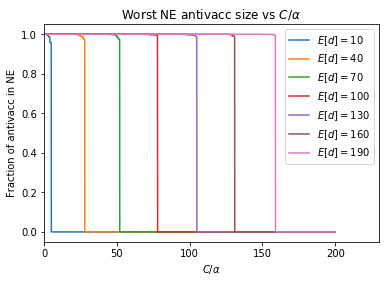

In [71]:
'7.2'

start = 0
end = 1001
interval = 1

c = np.arange(start, end, interval)

alpha = 1

wd = {}

for p in np.arange(0, 1, 0.2):
    N = 1000
    g = nx.erdos_renyi_graph(n=N, p = p, seed = 42)
    
    C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]
    
    worst_NE_size = []

    for C in C_list:
        S0 = get_S0(alpha = alpha, C = C, graph = g)

        theta = get_theta(graph= g, alpha = alpha, C = C)

        S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

        worst_NE_size.append(len(g)-len(S_T))

    wd.update({p:worst_NE_size})

    for i in range(len(worst_NE_size)):
        if(worst_NE_size[i] == 0):
            print(c[i])
            break

0
169
355
552
758


C:\Users\ah3wj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


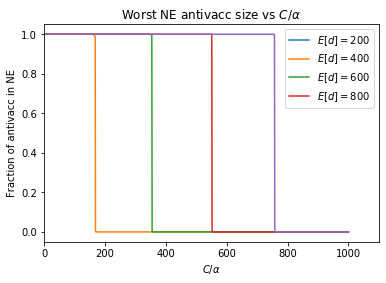

In [77]:
for d in wd:
    plt.plot(c, np.array(wd[d])/wd[d][0])


plt.xlim(0, 1100)

plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')


legend = [200,400,600,800]
legend = [r'$E[d] = $' + str(legend[i]) for i in range(len(legend))]

plt.legend(legend)
plt.savefig('wp.eps')

In [135]:
'7.6'

# g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
# g = nx.expected_degree_graph(w=[20 for i in range(N)], seed=42)
# g = nx.read_edgelist("../data/facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/twitter_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/email-EU-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
g = nx.read_edgelist("../data/p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_gexf("../data/twitter_sentiment_200.gexf", node_type=None, relabel=False, version='1.1draft')
# d = 5
# g = nx.random_regular_graph(d=d, n = N, seed = 42)



start = 0
end = 5
interval = 0.1
C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]

c = np.arange(start, end, interval)
worst_NE_size = []

alpha = 1

sorted_graph = sorted(g.degree, key = lambda x: x[1], reverse=True)





for k in range(0,1001,5):
  worst_NE_size = []
  Dk = set([sorted_graph[:k][i][1] for i in range(k)])

  for C in C_list:
      S0 = get_S0(alpha = alpha, C = C, graph = g).union(Dk)

      theta = get_theta(graph= g, alpha = alpha, C = C)

      S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)
      
      worst_NE_size.append(len(g)-len(S_T))
  
  for i in range(len(worst_NE_size)):
      if(worst_NE_size[i] == 0):
          print(c[i], end=', ')
          break

3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 

KeyboardInterrupt: 

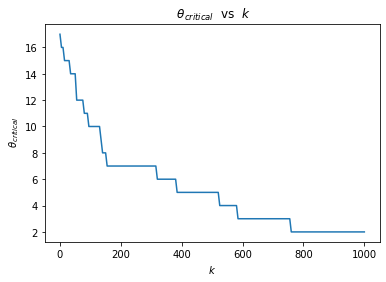

In [140]:
x = range(0,1001,5)

yemail = [17, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
yerdos = [169, 167, 167, 165, 165, 164, 163, 163, 163, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 161, 161, 161, 161, 161, 161, 161, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 153, 153, 153, 153, 153, 153, 153, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 150, 150, 150, 150, 150, 150, 150, 150, 149, 149, 149, 149, 149, 149, 148, 148, 148, 148, 148, 148, 148, 147, 147, 147, 147, 146, 146, 146, 146, 146, 144, 144, 143, 143, 143, 139]
yfacebook = [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93]

y_list = [yemail] 
legend = ['Erdos-Renyi', 'Facebook', 'email-EU-core', 'Gnutell p2p', 'Twitter Mentions']

for y in y_list:
  plt.plot(x,y)
  
plt.xlabel(r'$k$')
plt.ylabel(r' $\theta_{critical}$')
plt.title(r' $\theta_{critical}$  vs  $k$')
# plt.legend(legend)
plt.savefig('theta_vs_k.eps')